In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive
from scipy.signal import resample

from sklearn.cluster import KMeans
from sklearn.utils.linear_assignment_ import linear_assignment
from scipy.optimize import linear_sum_assignment
import sklearn.metrics

In [3]:
#init UCR archive helper class
ucr = UCRArchive()

#### Step 1: Create dataloaders
To run this notebook, you'll need the archive available here <https://www.cs.ucr.edu/~eamonn/time_series_data_2018/>
The password to the archive is 'someone'. Place the unziped directory in the same location as this nb.

The UCR Time Series Classification Archive contains 128 univariate timeseries data sets, of varying lengths and number of classes. They are presorted into training and validation sets, however the ratio between the two differs wildly from set to set. Below, I combine all the data and make my own validation set, set at 30% of the total data.

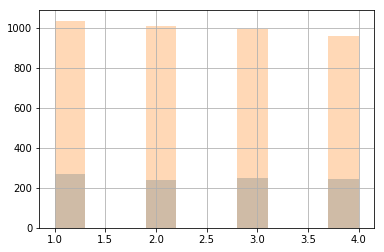

In [4]:
#Below are some datasets that seem to have good transfer properties:
#CinCECGTorso, MedicalImages, TwoPatterns, InsectWingbeatSound, UWaveGestureLibraryAll, WordSynonyms, SemgHandGenderCh2
dataset_name = "TwoPatterns"
#Visualize class distribution of initial train and validation sets
vc = ucr.category_distribution(dataset_name)

In [5]:
#All input is resampled down to a length of 96
class Resample(PreProcessor):
    def process_one(self,item):
        return np.concatenate([item[[0]],resample(item[1:],96)]) if len(item) > 97 else item

In [6]:
#Here we create the classification dataset. The fastai data_block api doesn't directly support what I am trying to do, namely
#remove most of the labels AFTER creating the validation set. Thus, a bit of hackery is required. 
#Not sure about the warning, seems to be ok...

src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
valIdxs = np.random.choice(len(src.items),int(len(src.items)*0.3),replace=False)
data = src.split_by_idx(valIdxs)
data = data.label_from_col()
idxs = np.random.choice(len(data.x),size=len(data.x)//10,replace=False)
bs = min(64,len(data.x)//50)
data.x.items = data.train.x.items[idxs]
data.y.items = data.train.y.items[idxs]
data = data.databunch(bs=bs,num_workers=0)
len(data.train_ds) #We end up with a training data set consisting of 10% of the training data as well as the full validation set

350

In [7]:
#Here we create the autocoder dataset. The differences are the data is labeled with itself, and that we use 
#the full amount of training data

src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
dataAE = src.split_by_idx(valIdxs)
dataAE = dataAE.label_from_col()
dataAE = dataAE.databunch(bs=bs,num_workers=0)
len(dataAE.train_ds) #Should be ~10x the classification size

3500

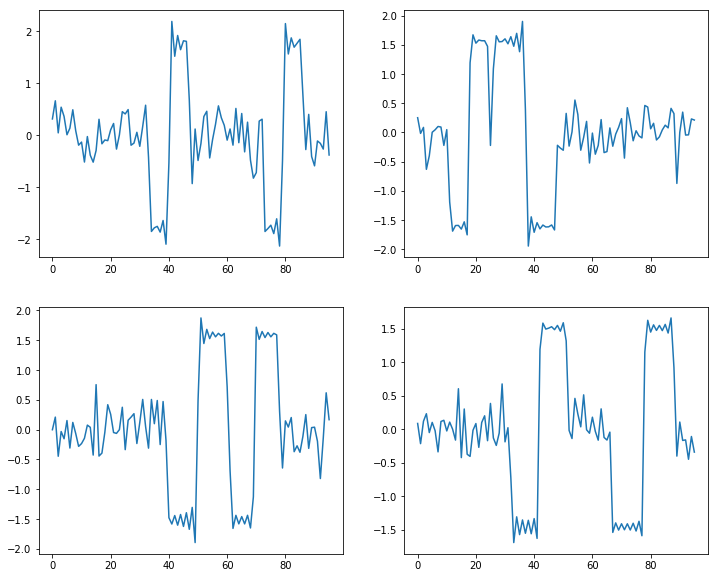

In [8]:
#Show a few inputs from the dataset
data.show_batch()

#### Step 2: Define models

In [9]:
#Helper functions, modified to 1d from fastai
def create_head_1d(nf:int, nc:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    return nn.Sequential(*layers)

def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

In [10]:
#This is the hero network, which serves as a backbone to all the other models
class HeroConvnet(nn.Module):
    def __init__(self, num_layers=3, start_nf=16, drop_p = 0.0):
        super().__init__()
        
        layers = [nn.Sequential(conv1d(1,start_nf,3,1),nn.LeakyReLU(0.2))] #First layer is stride 1, creates initial set of filters
        nf = start_nf
        for d in np.linspace(drop_p/10,drop_p,num_layers): #Then num_layers stride 2 convs, doubling the number of filters each layer
            layers.append(nn.Sequential(conv1d(nf,nf*2,3,2),nn.LeakyReLU(0.2)))
            nf *= 2
        
        self.nf = nf
        self.layers = nn.ModuleList(layers)
        self.avg = nn.AdaptiveAvgPool1d(1)
            
            
    def forward(self, x):
        actvns = [x]
        
        for l in self.layers:
            actvns.append(l(actvns[-1]))

        return self.avg(actvns[-1]), actvns[1:]

In [11]:
class BasicClassifier(nn.Module):
    def __init__(self,numClasses,num_layers=3,start_nf=16,drop_p=0.0):
        super().__init__()
        self.conv = HeroConvnet(num_layers,start_nf,drop_p=drop_p)
        self.out = create_head_1d(self.conv.nf,numClasses,ps=0.0)
              
    def forward(self,ts):
        ts = self.conv(ts.unsqueeze(1))[0].squeeze(-1)
        return self.out(ts)

In [12]:
#Basic variational autoencoder with hero net serving as encoder and a few linear layers as decoder
class TSAutoencoder(nn.Module):
    def __init__(self,seqLen,latentDim=12,num_layers=3,start_nf=16):
        super().__init__()
        self.conv = HeroConvnet(num_layers,start_nf)
        self.ls = torch.nn.Linear(self.conv.nf,latentDim)
        self.out = create_head_1d(latentDim,seqLen,lin_ftrs=[256,512],ps=0.0)
        
    def getLS(self,ts):
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)
        ls = self.ls(ts)
        return ls

    def forward(self,ts):
        seqLen = ts.shape[1]
        ots = ts
        ts, _ = self.conv(ts.unsqueeze(1))
        ts = ts.squeeze(-1)

        ls = self.ls(ts)
               
        return self.out(ls), ots

In [13]:
class Cluster(nn.Module):
    def __init__(self,num_classes,num_layers,start_nf):
        super().__init__()
        self.conv = HeroConvnet(num_layers,start_nf)
        self.ps = nn.Linear(self.conv.nf,num_classes)
        
    def forward(self,ts):
        ts, _ = self.conv(ts.unsqueeze(1))
        return self.ps(ts.squeeze(-1))

In [14]:
class MOA(nn.Module):
    def __init__(self,num_classes,seqLen,latentDim=12,num_layers=3,start_nf=16):
        super().__init__()
        self.aes = nn.ModuleList([TSAutoencoder(seqLen,latentDim,6,4) for _ in range(num_classes)])
        self.cluster = Cluster(num_classes,num_layers,start_nf)
        
    def getCluster(self,ts):
        ps = self.cluster(ts)
        ps = torch.softmax(ps,dim=1)
        return torch.argmax(ps,dim=1)
        
    def forward(self, ts):
        recon = [ae(ts)[0] for ae in self.aes]
        ps = self.cluster(ts)
        return ps, recon, ts

In [15]:
#The sidekick network mirrors the structure of the hero, but concats the output of each layer of the hero to the input of each 
#layer of the sidekick
class SidekickConvnet(nn.Module):
    def __init__(self, num_classes, num_layers=3, start_nf=16, start_nf_hero=16):
        super().__init__()
        
        self.hero = HeroConvnet(num_layers,start_nf_hero)
        
        layers = [nn.Sequential(conv1d(1,start_nf,3,1),nn.LeakyReLU(0.2))] 
        nf = start_nf
        nf_hero = start_nf_hero
        for _ in range(num_layers):
            layers.append(nn.Sequential(conv1d(nf+nf_hero,nf*2,3,2),nn.LeakyReLU(0.2)))
            nf *= 2
            nf_hero *= 2
        
        self.layers = nn.ModuleList(layers)
        #self.ll = conv1d(nf+nf_hero,nf+nf_hero,3,1)
        self.avg = nn.AdaptiveAvgPool1d(1)
        self.out = create_head_1d(nf + nf_hero,num_classes,ps=0.0)
    
    def forward(self,ts):
        ts = ts.unsqueeze(1)
        pt, actvns = self.hero(ts)
        
        x = self.layers[0](ts)
        for l,a in zip(self.layers[1:],actvns):
            x = l(torch.cat([x,a],dim=1))
            
        x = torch.cat([self.avg(x),pt],dim=1).squeeze(-1)
        #x = self.ll(torch.cat([x,actvns[-1]],dim=1))
        #x = self.avg(x).squeeze(-1)
        return self.out(x)

#### Step 3: Get Baseline

In [16]:
learnBase = Learner(data,BasicClassifier(data.train_ds.c,8,8,drop_p=0.0),loss_func=F.cross_entropy,metrics=[accuracy])

In [ ]:
# Run one batch through the model to make sure the output size is correct
learnBase.model(next(iter(data.train_dl))[0]).size()

In [ ]:
#Learning rate finder
learnBase.lr_find()
learnBase.recorder.plot()

In [17]:
learnBase.fit_one_cycle(20,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,1.394590,1.381884,0.265333
2,1.165905,1.358307,0.358667
3,0.941310,1.282704,0.502667
4,0.750283,1.113496,0.600000
5,0.600082,0.865146,0.717333
6,0.488579,0.685421,0.738667
7,0.403138,0.616798,0.750000
8,0.336675,0.608999,0.745333
9,0.284411,0.514250,0.787333
10,0.242883,0.516855,0.790667


#### Step 4: Autoencoder

In [18]:
class ClusterAccuracy(LearnerCallback):
    _order=-20
    def __init__(self,learn):
        super().__init__(learn)
    def on_train_begin(self, **kwargs):
        self.learn.recorder.add_metric_names(["cluster_accuracy"])
        
    def on_epoch_end(self,**kwargs):
        self.learn.model.eval()
        dl = torch.utils.data.DataLoader(self.learn.data.train_ds,batch_size=64,collate_fn=data_collate)
        labels_pred, labels_true = [],[]
        
        with torch.no_grad():
            for ts,labels in iter(dl):
                ts = ts.cuda()
                labels_pred.append(self.learn.model.getCluster(ts).cpu().detach().numpy())
                labels_true.append(labels.numpy())
        labels_pred = np.concatenate(labels_pred)
        labels_true = np.concatenate(labels_true)
        labels_true = labels_true.astype(np.int64)
        assert labels_pred.size == labels_true.size
        
        D = max(labels_pred.max(), labels_true.max()) + 1
        w = np.zeros((D, D), dtype=np.int64)
        for i in range(labels_pred.size):
            w[labels_pred[i], labels_true[i]] += 1
        ind = linear_assignment(w.max() - w)
        #self.metric = torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)
        self.learn.recorder.add_metrics([torch.tensor(sum([w[i, j] for i, j in ind]) * 1.0 / labels_pred.size)])

In [19]:
def AELoss(pred,target):
    return F.mse_loss(pred[0],pred[1])

In [21]:
class MOALoss(torch.nn.Module):
    def forward(self,p,target):
        p,recon, ts = p
        p = torch.softmax(p,dim=1)
        rerrs = torch.stack([torch.exp(-0.5 * ((ts-r)**2).sum(dim=1)) for r in recon],dim=1)
        berr = (p * rerrs).sum(dim=1)
        berr = torch.log(berr)
        return -berr.sum()

In [22]:
learnAE = Learner(dataAE,MOA(data.train_ds.c,len(data.train_ds[0][0].data),latentDim=12,num_layers=8,start_nf=8),
                  loss_func=MOALoss(),callback_fns=[ClusterAccuracy])

In [23]:
learnAE.model(next(iter(data.train_dl))[0])[0].size()

torch.Size([64, 4])

In [ ]:
learnAEInit = Learner(dataAE,TSAutoencoder(len(data.train_ds[0][0].data),num_layers=8,start_nf=8),loss_func=AELoss)

In [ ]:
learnAEInit.fit_one_cycle(20,1e-2)

In [ ]:
learnAEInit.model.eval()
out = []
dl = torch.utils.data.DataLoader(dataAE.train_ds,batch_size=64,collate_fn=data_collate)
with torch.no_grad():
    for x,y in iter(dl):
        ls = learnAEInit.model.getLS(x.cuda())
        out.append(ls)
out = torch.cat(out).cpu().detach().numpy()

kmeans = KMeans(n_clusters=data.train_ds.c,n_init=20)
kmeans.fit_predict(out)

def assignClusters(x):
    x = resample(x[1:],96)
    ls = learnAEInit.model.getLS(torch.tensor(x,dtype=torch.float).unsqueeze(0).cuda())
    pred =  kmeans.predict(ls.cpu().detach().numpy())[0]
    return pred

In [ ]:
src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
dataAEInit = src.filter_out_idx(valIdxs)
dataAEInit = dataAEInit.no_split()
dataAEInit = dataAEInit.label_from_func(assignClusters)
dataAEInit = dataAEInit.databunch(bs=bs,num_workers=0)

In [ ]:
plt.hist(dataAEInit.train_ds.y.items)

In [24]:
learnClusterInit = Learner(data,learnAE.model.cluster,loss_func=F.cross_entropy,metrics=accuracy)

In [25]:
learnClusterInit.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.364763,1.349353,0.374667
2,1.305988,1.255152,0.454000
3,1.192828,1.130247,0.499333
4,1.039001,0.968712,0.639333
5,0.861988,0.738324,0.743333
6,0.751021,0.685751,0.767333
7,0.641420,0.745737,0.770000
8,0.553338,0.407121,0.856667
9,0.491236,0.469505,0.855333
10,0.424413,0.403795,0.869333


In [53]:
for c,m in enumerate(learnAE.model.aes):
    src = TimeSeriesList.from_csv_list(ucr.get_csv_files(dataset_name),labelCol=0,processor=Resample())
    dataExpert = src.filter_out_idx(valIdxs)
    dataExpert = dataExpert.no_split()
    dataExpert.train.filter_by_func(lambda x: assignClusters(x) == c)
    dataExpert = dataExpert.label_from_self()
    dataExpert = dataExpert.databunch(bs=4,num_workers=0)
    
    learnExpert = Learner(dataExpert,m,loss_func=AELoss)
    learnExpert.fit_one_cycle(5,1e-2)

NameError: name 'assignClusters' is not defined

In [26]:
for c,m in enumerate(learnAE.model.aes):
    d = data.train_ds.x.items.copy()
    src = TimeSeriesList.from_numpy(d,labeled=0)
    src = src.filter_by_func(lambda x: int(x[0]) - 1 == c)
    dataExpert = src.no_split()
    dataExpert = dataExpert.label_from_self()
    dataExpert = dataExpert.databunch(bs=4,num_workers=0)
    
    learnExpert = Learner(dataExpert,m,loss_func=AELoss)
    learnExpert.fit_one_cycle(20,1e-2)

In [ ]:
torch.save(learnAE.model.state_dict(),"init.pth")

In [ ]:
learnAE.model.load_state_dict(torch.load("init.pth"))

In [ ]:
learnAE.lr_find()
learnAE.recorder.plot()

In [ ]:
learnAE = Learner(dataAE,learnAE.model,loss_func=MOALoss(),callback_fns=[ClusterAccuracy])

In [27]:
learnAE.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,cluster_accuracy
1,15.248502,14.388304,0.856571
2,13.828208,12.144245,0.794286
3,12.888902,12.307667,0.419429
4,12.328094,10.891732,0.448286
5,12.396356,11.548126,0.328857
6,11.584217,10.423244,0.332571
7,10.642795,9.464816,0.338000
8,9.881576,9.058051,0.339429
9,9.465524,8.941978,0.338857
10,9.271304,8.921819,0.338571


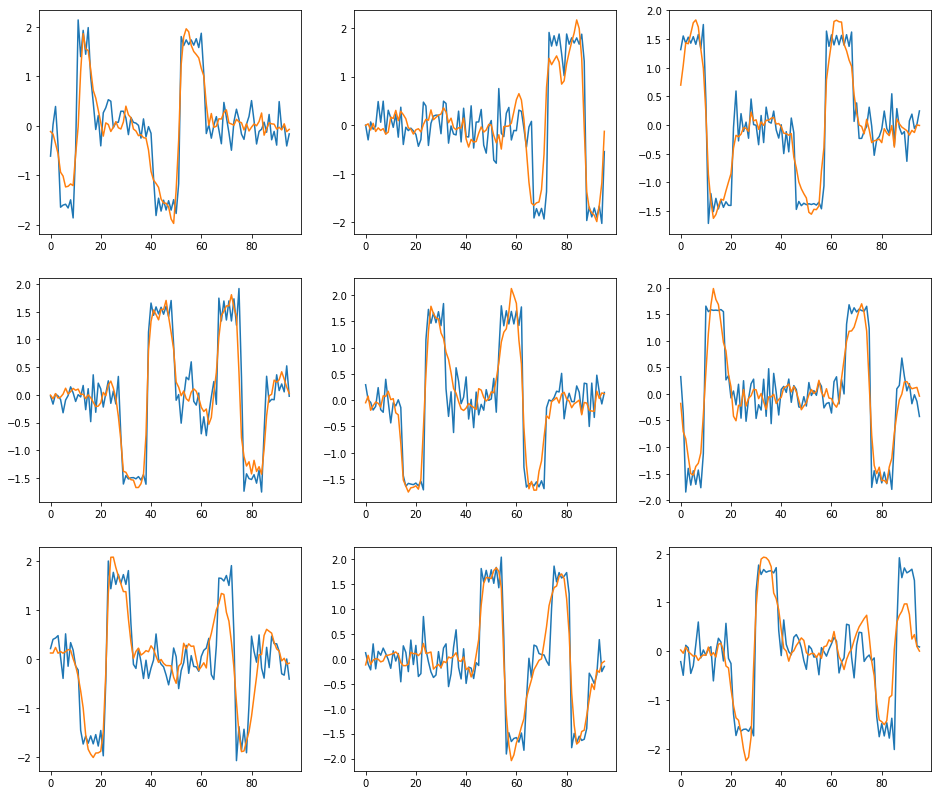

In [60]:
x,y = next(iter(dataAE.train_dl))
learnAE.model.eval()
ps,recon,ts = learnAE.model(x)
ps = torch.softmax(ps,dim=1)
ps = torch.argmax(ps,dim=1)
fig, axes = plt.subplots(3,3,figsize=(16,14))
for i,ax in enumerate(axes.flatten()):
    pred = ps[i].item()
    ax.plot(x[i])
    ax.plot(recon[pred][i])

In [ ]:
#Optional: Visualize latent space
learnAE.model.eval()
out = []
classes = []
with torch.no_grad():
    for x,y in iter(data.valid_dl):
        ls = learnAE.model.mean(learnAE.model.conv(x.unsqueeze(1))[0].squeeze(-1))
        out.append(ls)
        classes.append(y)
out = torch.cat(out).cpu().detach().numpy()
classes = torch.cat(classes).cpu().detach().numpy()

In [ ]:
pca = PCA(n_components=2)
f = pca.fit(out.T)
f = f.components_.T
plt.subplots(figsize=(20,15))
style = classes if data.train_ds.c < 8 else None
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=style,legend="full",s=50)

In [ ]:
tsne = TSNE(n_components=2)
f = tsne.fit_transform(out)
plt.subplots(figsize=(20,15))
sns.scatterplot(x=f[:,0],y=f[:,1],hue=classes,palette="Dark2",style=style,legend="full",s=50)

#### Step 5: Traditional transfer
Here we train a classifier by just adding a classifier head onto the encoder from the previous step

In [26]:
learnDT = Learner(data,BasicClassifier(data.train_ds.c,8,8),loss_func=F.cross_entropy,metrics=[accuracy],
                 callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnDT.split([*learnDT.model.conv.layers,learnDT.model.conv.avg,learnDT.model.out])

In [27]:
#Load the parameters from the encoder
learnDT.model.conv.load_state_dict(learnAE.model.cluster.conv.state_dict())

In [28]:
#Freeze up to the classifier layer
learnDT.freeze_to(-1)

In [29]:
learnDT.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy
1,2.125969,2.241078,0.546970
2,1.732726,1.864955,0.590909
3,1.436036,1.431720,0.586364
4,1.262841,1.225137,0.600000
5,1.133190,1.203084,0.595455
6,1.040897,1.210992,0.600000
7,0.979761,1.233358,0.596970
8,0.924566,1.190132,0.593939
9,0.878520,1.147774,0.592424
10,0.834077,1.180569,0.596970


In [ ]:
#Fine tune
learnDT.unfreeze()
learnDT.fit_one_cycle(100,1e-4)

#### Step 6: Sidekick network

In [61]:
learnSidekick = Learner(data,SidekickConvnet(data.train_ds.c,8,8,8), loss_func=F.cross_entropy,metrics=[accuracy],
                        callback_fns=BnFreeze,bn_wd=False,train_bn=False)
learnSidekick.split([learnSidekick.model.hero,learnSidekick.model.layers[0],learnSidekick.model.out])

RuntimeError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 8.00 GiB total capacity; 792.16 MiB already allocated; 0 bytes free; 68.34 MiB cached)

In [33]:
learnSidekick.model(next(iter(data.train_dl))[0]).size()

torch.Size([30, 11])

In [34]:
learnSidekick.model.hero.load_state_dict(learnAE.model.cluster.conv.state_dict())
learnSidekick.freeze_to(1)

In [ ]:
learnSidekick.lr_find()
learnSidekick.recorder.plot()

In [35]:
learnSidekick.fit_one_cycle(20,1e-3,wd=0.2)

epoch,train_loss,valid_loss,accuracy
1,1.902544,2.168012,0.551515
2,1.415446,1.687520,0.587879
3,1.184208,1.270837,0.592424
4,1.037721,1.172526,0.596970
5,0.923211,1.180639,0.607576
6,0.821377,1.187550,0.619697
7,0.731106,1.331244,0.606061
8,0.652346,1.366042,0.600000
9,0.594465,1.419742,0.609091
10,0.531255,1.473732,0.565152
